# Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_style('dark')
import matplotlib.pyplot as plt
#import re
import os
import pickle
from collections import defaultdict
from keras.utils import np_utils, to_categorical

import keras
from keras.models import Model, Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, GlobalAveragePooling2D, InputLayer
from keras.applications import mobilenet_v2
from keras.preprocessing import image

from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import train_test_split

# Preprocessing Functions

In [2]:
def prepare_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = mobilenet_v2.preprocess_input(x)
    return x

# Classification Models

## Binary Classification

In [3]:
directory_rwbb = 'data/CUB_200_2011/images/010.Red_winged_Blackbird/'
directory_cww = 'data/CUB_200_2011/images/186.Cedar_Waxwing/'

rwbbs = []
cwws = []
y2 = np.array(([1]*60) + ([0]*60))


for filename in os.listdir(directory_rwbb):
    if filename.endswith(".jpg"):
        filename = directory_rwbb + filename
        #print(filename)
        rwbbs.append(prepare_image(filename).reshape(224,224,3))
        
for filename in os.listdir(directory_cww):
    if filename.endswith(".jpg"):
        filename = directory_cww + filename
        #print(filename)
        cwws.append(prepare_image(filename).reshape(224,224,3))
        
x2 = np.array(rwbbs + cwws)

In [4]:
X_train, X_test, y_train, y_test = (train_test_split(x2, y2, 
                                                     test_size = .2, random_state = 23))

In [5]:
# Simple CNN classifier comparing only 2 species (redwing blackbird and cedar waxwing)
NN = Sequential()

NN.add(InputLayer(input_shape=X_train.shape[1:]))

# Convolutional block 1
NN.add(Conv2D(filters=10, kernel_size=3, activation='relu', padding='same'))
# NN.add(Conv2D(filters=16, kernel_size=3, activation='relu', padding='same'))
NN.add(MaxPooling2D())

# Convolutional block 2
NN.add(Conv2D(filters=25, kernel_size=3, activation='relu', padding='same'))
# NN.add(Conv2D(filters=16, kernel_size=3, activation='relu', padding='same'))
NN.add(MaxPooling2D())

# Convolutional block 3
NN.add(Conv2D(filters=50, kernel_size=3, activation='relu', padding='same'))

# Fully connected block
NN.add(Flatten())
NN.add(Dense(30, activation='relu'))
NN.add(Dense(1, activation='sigmoid'))  # sigmoid for binary, softmax(?) for multiclass

NN.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy'],
)
NN.summary()
NN.fit(X_train, y_train,
       epochs=10,
       batch_size = 50,
       verbose=1, #validation_split=0.25,
       callbacks=[
           keras.callbacks.ModelCheckpoint(
               'models/rwbb_cww_1.hdf5',
               save_best_only=True)
       ])  # track fit progress

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 10)      280       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 10)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 25)      2275      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 25)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 50)        11300     
_________________________________________________________________
flatten (Flatten)            (None, 156800)            0         
_________________________________________________________________
dense (Dense)                (None, 30)                4

In [6]:
accuracy_score(y_test, NN.predict_classes(X_test))

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


0.6666666666666666

## Multiclass Classification

In [7]:
import os

# organize bird images to be classified
bird_directories = []
directory_rwbb = 'data/CUB_200_2011/images/010.Red_winged_Blackbird/'
bird_directories.append(directory_rwbb)
directory_cww = 'data/CUB_200_2011/images/186.Cedar_Waxwing/'
bird_directories.append(directory_cww)
directory_gcb = 'data/CUB_200_2011/images/019.Gray_Catbird/'
bird_directories.append(directory_gcb)
directory_dwp = 'data/CUB_200_2011/images/192.Downy_Woodpecker/'
bird_directories.append(directory_dwp)


rwbbs = []
cwws = []
gcbs = []
dwps = []
y = []
x = []

image_dict = defaultdict(list)

#add images and labels for each species to x and y variables
for idx, directory in enumerate(bird_directories):

    for filename in os.listdir(directory):
        if filename.endswith(".jpg"):
            filename = directory + filename
            image_dict[directory].append(prepare_image(filename).reshape(224,224,3))
            x.append(prepare_image(filename).reshape(224,224,3))
            y.append(idx)
        
x = np.array(x)
y = np.array(y)

In [8]:
X_train, X_test, y_train, y_test = (train_test_split(x, y, 
                                                     test_size = .2, random_state = 25))
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [9]:
# Simple CNN classifier - multiclass
NNmulti = Sequential()

NNmulti.add(InputLayer(input_shape=X_train.shape[1:]))

# Convolutional block 1
NNmulti.add(Conv2D(filters=10, kernel_size=3, activation='relu', padding='same'))
NNmulti.add(MaxPooling2D())

# Convolutional block 2
NNmulti.add(Conv2D(filters=25, kernel_size=3, activation='relu', padding='same'))
NNmulti.add(MaxPooling2D())

# Convolutional block 3
NNmulti.add(Conv2D(filters=50, kernel_size=3, activation='relu', padding='same'))

# Fully connected block - global pooling followed by dense and output layers
NNmulti.add(GlobalAveragePooling2D())
NNmulti.add(Dense(20, activation='relu'))
NNmulti.add(Dense(4, activation='softmax'))  # softmax for multiclass

NNmulti.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy'],
)
NNmulti.summary()
NNmulti.fit(X_train, y_train, epochs=5, verbose=1, #validation_split=0.25,
       callbacks=[
           keras.callbacks.ModelCheckpoint(
               'models/rwbb_cww_gcb.hdf5',
               save_best_only=True)
       ])  # track fit progress


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 224, 224, 10)      280       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 112, 112, 10)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 112, 112, 25)      2275      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 56, 56, 25)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 56, 56, 50)        11300     
_________________________________________________________________
global_average_pooling2d (Gl (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 20)               

In [10]:
accuracy_score(np.argmax(y_test, axis=1), np.argmax(NNmulti.predict(X_test),axis=1))

0.3333333333333333

Not very good at all considering 0.25 would be as good as guessing. There are probably many other incremental improvements that could be made to this model, but I'm guessing I won't see significant improvements until I incorporate transfer learning.

### Transfer Learning

#### MobileNetV2

In [11]:
#Start with pre-trained base minus top layer
base_model = mobilenet_v2.MobileNetV2(weights='imagenet',
                                      include_top=False, input_shape=(224,224,3)
                                     ) 
 
#Freeze convolutional layers
for layer in base_model.layers:
    layer.trainable = False    

#New fully connected block
x = base_model.output
x = Flatten()(x)
x = Dense(100, activation='relu')(x)
x = Dense(50, activation='relu')(x)
predictions = Dense(4, activation='softmax')(x) #first dense() parameter should match number of output classes

#Create new model combining base_model and custom fully connected block
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
model.fit(X_train, y_train)

6/6 [==============================] - 3s 525ms/step - loss: 2.6139 - accuracy: 0.6649


In [13]:
print(accuracy_score(np.argmax(y_train,axis=-1), np.argmax(model.predict(X_train), axis=-1)))
print(accuracy_score(np.argmax(y_test,axis=-1), np.argmax(model.predict(X_test), axis=-1)))

0.9057591623036649
0.875


Remarkably better right off the bat.

#### MobileNetV2 Classifying by 'Type'

36 species is quite a lot. Before tackling that, I'll try to see how well I can classify between "types", where "types" are superclasses I made by combining similar species. Depending on how much better the accuracy score is, this might be a more useful model as far as sorting my photos goes.

In [15]:
# organize bird images to be classified
types_list = ['catbirds','crows','hummingbirds','ravens','sparrows','terns','woodpeckers','wrens']
root_folder = '../../Desktop/birdup/birds_by_type/'
bird_directories = []
directory_catbirds = root_folder + types_list[0] + '/'
bird_directories.append(directory_catbirds)
directory_crows = root_folder + types_list[1] + '/'
bird_directories.append(directory_crows)
directory_hummingbirds = root_folder + types_list[2] + '/'
bird_directories.append(directory_hummingbirds)
directory_ravens = root_folder + types_list[3] + '/'
bird_directories.append(directory_ravens)
directory_sparrows = root_folder + types_list[4] + '/'
bird_directories.append(directory_sparrows)
directory_terns = root_folder + types_list[5] + '/'
bird_directories.append(directory_terns)
directory_woodpeckers = root_folder + types_list[6] + '/'
bird_directories.append(directory_woodpeckers)
directory_wrens = root_folder + types_list[7] + '/'
bird_directories.append(directory_wrens)


#catbirds = []
#crows = []
#hummingbirds = []
#ravens = []
#sparrows = []
#terns = []
#woodpeckers = []
#wrens = []
y = []
x = []

image_dict = defaultdict(list)

#add images and labels for each species to x and y variables
for idx, directory in enumerate(bird_directories):

    for filename in os.listdir(directory):
        if filename.endswith(".jpg"):
            filename = directory + filename
            image_dict[directory].append(prepare_image(filename).reshape(224,224,3))
            x.append(prepare_image(filename).reshape(224,224,3))
            y.append(idx)
        
x = np.array(x)
y = np.array(y)

No need to include modeling blocks after here. If you wish to use the "types" classifier, skip ahead to the train-test split.

#### MobileNetV2 Classifying by Species

After regularly hitting ~90% on the "types" classification, it is time to move on to the real goal: a species-level classifier.

In [20]:
### DATA CONSTRUCTOR FOR FINAL MODEL
# create x array of images and y array of labels from images in specified folder

root_folder = '../../Desktop/birdup/birds_by_species/'

y = []
x = []
y_labels = defaultdict(str)

image_dict = defaultdict(list)

for idx, folder in enumerate(os.listdir(root_folder)):
    y_labels[idx] = folder[4:]
    for file in os.listdir(root_folder + folder):
        if file.endswith(".jpg"):
            file = root_folder + folder + '/' + file
            image_dict[folder].append(prepare_image(file).reshape(224,224,3))
            x.append(prepare_image(file).reshape(224,224,3))
            y.append(idx)
            
test_image = x[0]
        
x = np.array(x)
y = np.array(y)


In [21]:
#Train-test split 
X_train, X_test, y_train, y_test = (train_test_split(x, y, 
                                                     test_size = .2, random_state = 23))
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

#### Final Model

In [22]:
base_model = mobilenet_v2.MobileNetV2(weights='imagenet',
                                      include_top=False, input_shape=(224,224,3)
                                     ) 
 
#Freeze convolutional layers
for layer in base_model.layers:
    layer.trainable = False    

#New fully connected block
x = base_model.output
x = Flatten()(x)
x = Dense(100, activation='relu')(x)
x = Dense(50, activation='relu')(x)
predictions = Dense(36, activation='softmax')(x)

# define formal model object to train and compile it as usual
MNV2_model = Model(inputs=base_model.input, outputs=predictions)
MNV2_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [23]:
MNV2_model.fit(X_train, y_train, epochs=5, verbose=1)

print(accuracy_score(np.argmax(y_train,axis=-1), np.argmax(MNV2_model.predict(X_train), axis=-1)))
print(accuracy_score(np.argmax(y_test,axis=-1), np.argmax(MNV2_model.predict(X_test), axis=-1)))

Epoch 1/5
54/54 [==============================] - 37s 679ms/step - loss: 3.4920 - accuracy: 0.1469
Epoch 2/5
54/54 [==============================] - 36s 661ms/step - loss: 1.7414 - accuracy: 0.4994
Epoch 3/5
54/54 [==============================] - 34s 626ms/step - loss: 0.7028 - accuracy: 0.7886
Epoch 4/5
54/54 [==============================] - 34s 627ms/step - loss: 0.2602 - accuracy: 0.9268
Epoch 5/5
54/54 [==============================] - 34s 621ms/step - loss: 0.1297 - accuracy: 0.9681
0.9941927990708479
0.6194895591647331


# Confusion Matrix

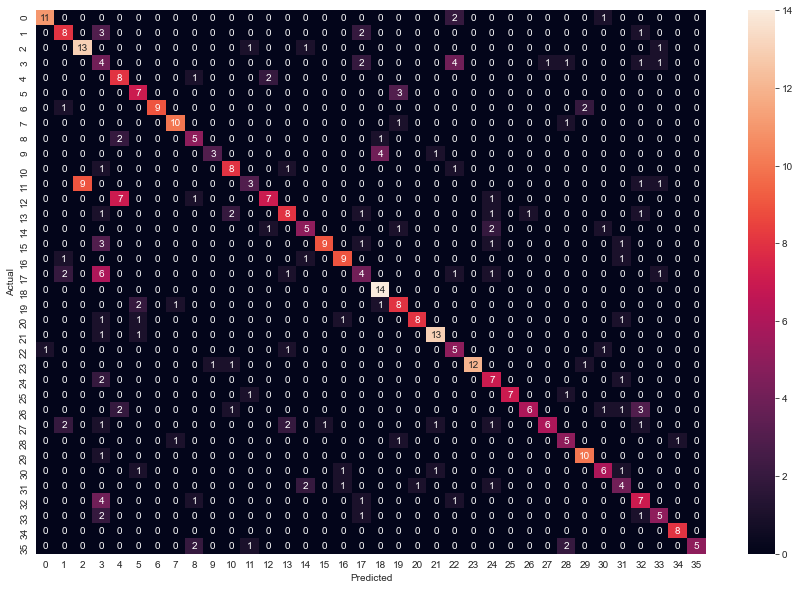

In [24]:
cm = confusion_matrix(np.argmax(y_test,axis=-1), np.argmax(MNV2_model.predict(X_test), axis=-1))
plt.figure(figsize=(15,10))
sns.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Save Final Model

In [ ]:
#MNV2_model.save("MNV2_species")